In [1]:
import pandas as pd 
import geopandas as gp
import altair as alt 
import gpdvega 
import json
import matplotlib.pyplot as plt
alt.renderers.enable('notebook') # render for Jupyter Notebook

DATA_DIR = '/nas/dft/ire/stuartlynn/MTA_ACCESSIBILITY/MTAAlertScraper-master/data/'
DATA_DIR2 = '/nas/dft/ire/kmohan/hackday_2019_q4_mta_accessibility/data/'

turnstile = pd.read_pickle(DATA_DIR2+"turnstile_new.pkl.gz")

outages = pd.read_csv(DATA_DIR+"outages.csv.gz" )
outages['Outage start'] = pd.to_datetime(outages['Outage start'], format='%Y-%m-%d %H:%M:%S')
outages['Outage end'] = pd.to_datetime(outages['Outage end'], format='%Y-%m-%d %H:%M:%S')

daily_data = (outages.groupby(['Equipment number', 'Station',outages['Outage start'].dt.floor('d')])
                    .Duration.sum()
                    .reset_index()
                    .assign(day = lambda x: x['Outage start'].dt.day, month = lambda x: x['Outage start'].dt.month)
                    .set_index('Equipment number'))

remote_station = pd.read_excel(DATA_DIR + 'Remote-Booth-Station.xls')

In [2]:
turnstile.head()

In [3]:
subway_turnstile = pd.read_csv(DATA_DIR+'subway_turnstile_join.csv')


In [4]:
subway_turnstile[subway_turnstile['name']=='Union Sq - 14th St']

In [5]:
def join_st(station):
    atlantic_ave = turnstile[(turnstile.STATION==station) &  (turnstile.datetime.dt.year==2019)]
    turnstile_data_by_day = atlantic_ave[ (atlantic_ave.entry_diff.abs() < 2000) & (atlantic_ave.exit_diff.abs() < 2000) ].assign(day=atlantic_ave.datetime.dt.day, month = atlantic_ave.datetime.dt.month).groupby(['day','month']).sum()[['entry_diff', 'exit_diff']].reset_index()

    out_station = get_outage_station(station)
    atl_daily_outage = daily_data[daily_data['Station'] == out_station]

    atl_daily_outage = atl_daily_outage.reset_index()
    joined = pd.merge(atl_daily_outage, turnstile_data_by_day, on=['day', 'month'])
    joined.sort_values(by=['month', 'day'])

In [6]:
eem = pd.read_csv('EE_master_list.csv')
eem.rename(columns={'st_name_opd_format': 'name'}, inplace=True)
mapping = pd.merge(eem, subway_turnstile, on='name')
# [['station_name', 'name', 'station']].drop_duplicates()


t_ust = turnstile[['UNIT', 'STATION']].drop_duplicates()

t_ust = t_ust.rename(columns={'UNIT': 'Remote'})

# t_ust[t_ust['STATION'].str.contains('34')]

tst = t_ust.set_index('Remote').join(remote_station.set_index('Remote'))[['STATION', 'Station', 'Line Name']]

tst.rename(columns={'STATION': 'Turnstile_station', 'Station': 'remote_station'}, inplace=True)

tst.reset_index(inplace=True)

tst['Line Name'] = tst['Line Name'].astype('str')

sst = pd.merge(tst, subway_turnstile, how='left', left_on=['remote_station', 'Line Name'], right_on=['station', 'line_name'])[['Turnstile_station', 'remote_station', 'name', 'line', 'Line Name']]

sst.rename(columns={'name': 'subway_station'}, inplace=True)

tst[tst['Turnstile_station'].str.contains('125')]

tmp = sst.fillna('')

In [7]:
tmp[tmp['remote_station'].str.contains('125')]

In [8]:
tst[tst['Turnstile_station'].str.contains('125')]['Line Name'].unique()

array(['1', 'ACBD', '456', '23'], dtype=object)

In [9]:
stmp = subway_turnstile.fillna('')
stmp[stmp['station'].str.contains('125')]['line_name'].unique()

array(['23', '1', '456'], dtype=object)

In [10]:
eem.head()

In [11]:
fst = pd.merge(sst, eem, how='left', left_on=['subway_station', 'line'], right_on=['name', 'line'])[['Turnstile_station', 'remote_station', 'subway_station', 'line', 'station_name', 'equipment_id', 'name', 'Line Name']]

In [12]:
fst[fst.Turnstile_station.str.contains('ATL')]

In [13]:
fst.to_csv('turnstile_to_outage_line_name.csv')

In [14]:
fst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2202 entries, 0 to 2201
Data columns (total 8 columns):
Turnstile_station    2202 non-null object
remote_station       2198 non-null object
subway_station       1977 non-null object
line                 1977 non-null object
station_name         1406 non-null object
equipment_id         1406 non-null object
name                 1406 non-null object
Line Name            2202 non-null object
dtypes: object(8)
memory usage: 154.8+ KB


In [15]:
eem[eem['station_name'].str.contains('White')]

In [16]:
def get_outage_station(st):
    return fst[fst['Turnstile_station'] == st]['name']

In [17]:
tout = pd.merge(daily_data.reset_index(), fst, how='left', left_on='Equipment number', right_on='equipment_id')

In [18]:
tout.head()

In [19]:
turnstile.reset_index(inplace=True)

In [20]:

t19 = turnstile[turnstile.datetime.dt.year==2019]
turnstile_data_by_day = t19[(t19.entry_diff_abs < 4000) & (t19.exit_diff_abs < 4000)].assign(day=t19.datetime.dt.day, month = t19.datetime.dt.month).groupby(['day','month', 'STATION', 'LINENAME']).sum()[['entry_diff_abs', 'exit_diff_abs']].reset_index()
turnstile_data_by_day.head(20)

In [21]:
tout.head()

In [22]:
e_turns = pd.merge(tout, turnstile_data_by_day, how='left', left_on=['Turnstile_station', 'line' , 'month', 'day'], right_on=['STATION', 'LINENAME', 'month', 'day'])

In [23]:
e_turns.columns

Index(['Equipment number', 'Station', 'Outage start', 'Duration', 'day',
       'month', 'Turnstile_station', 'remote_station', 'subway_station',
       'line', 'station_name', 'equipment_id', 'name', 'Line Name', 'STATION',
       'LINENAME', 'entry_diff_abs', 'exit_diff_abs'],
      dtype='object')

In [24]:
e_turns.drop(['Turnstile_station', 'remote_station', 'name','equipment_id'], axis=1, inplace=True)

In [25]:
e_turns.head()

In [26]:
e_turns['flow_abs'] = e_turns['entry_diff_abs'] + e_turns['exit_diff_abs']

In [27]:
e_turns['Duration'].describe()

count    80906.000000
mean         4.627790
std          4.639232
min          0.000278
25%          1.459444
50%          3.200278
75%          5.901111
max         37.922500
Name: Duration, dtype: float64

In [28]:
e_turns['Duration'] = e_turns['Duration'] / 24 


In [29]:
e_turns['score'] = e_turns['Duration'] * e_turns['flow_abs']
result = e_turns.groupby(['Equipment number', 'Station']).sum()['score'].sort_values( ascending=False)

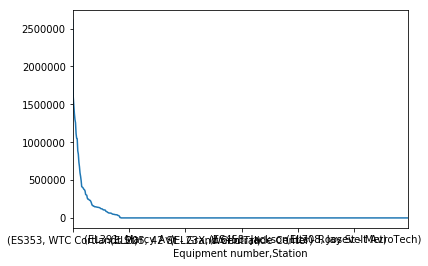

In [30]:
result.plot()

In [31]:
e_turns.head()

In [32]:
t19.head()

In [33]:
turn_avg = turnstile_data_by_day.groupby(['STATION', 'LINENAME']).mean()[['entry_diff_abs', 'exit_diff_abs']].reset_index()

In [34]:
turn_avg['flow_abs'] = turn_avg['entry_diff_abs'] + turn_avg['exit_diff_abs']

In [35]:
turn_avg.head()

In [36]:
e_turns.head()

In [37]:
metric_day = pd.merge(e_turns, turn_avg, how='left', left_on=['STATION', 'LINENAME'], right_on=['STATION', 'LINENAME'])

In [38]:
metric_day['day_score'] = metric_day['score'] / metric_day['flow_abs_y']

In [39]:
metric_day.sort_values(by='day_score', ascending=False).to_csv('final_score.csv', index=None)

In [40]:
metric_day[metric_day['Equipment number'] == 'ES217']

In [51]:
geo_final_score.plot()

ValueError: view limit minimum -36868.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f61f90ad378> (for post_execute):


ValueError: view limit minimum -36868.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36868.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [41]:
valid_turnstile = turnstile[(turnstile.entry_diff.abs() < 3000) & (turnstile.exit_diff.abs() < 3000)]        # Get rid of outliers
daily_station_counts = valid_turnstile.groupby(['STATION','LINENAME', valid_turnstile.datetime.dt.floor('d')]).sum()[[    # Group by station and day and sum
    'entry_diff',                                                                                              # Select only the entry and exit columns
    'exit_diff'
]].reset_index()       

geo_joined_daily_data = gp.GeoDataFrame(
     pd.merge(
        daily_station_counts,
        subway_turnstile, 
        left_on=['STATION', 'LINENAME'],
        right_on=['station','line_name']
    ).set_index('datetime')
)

In [54]:
from shapely import wkt

In [64]:
geo_stations.geometry = geo_stations.geometry.apply(wkt.loads)

subway_station  line           
125th St        1                  0.261263
                4-5-6-6 Express         NaN
                A-B-C-D                 NaN
135th St        2-3                     NaN
145th St        A-B-C-D                 NaN
Name: day_score, dtype: float64

In [83]:
consolidated_metric = metric_day.groupby(['subway_station','line']).mean()['day_score']
# consolidated_metric.reset_index().rename(columns={'subway_station':'name'},inplace=True)

In [87]:
consolidated_metric = consolidated_metric.reset_index().rename(columns={'subway_station': 'name'})

In [90]:
geo_plot_df = geo_stations.merge(consolidated_metric,on='name')

In [97]:
geo_plot_df.fillna(0,inplace=True)

In [70]:
geo_final_score = gp.merge(consolidated_metric, geo_stations, how="left", left_on="subway_station", right_on="name")
geo_final_score.dropna(inplace=True)
geo_final_score['geometry'] = geo_final_score['geometry'].apply(wkt.loads)
geo_final_score.groupby()

AttributeError: module 'geopandas' has no attribute 'merge'

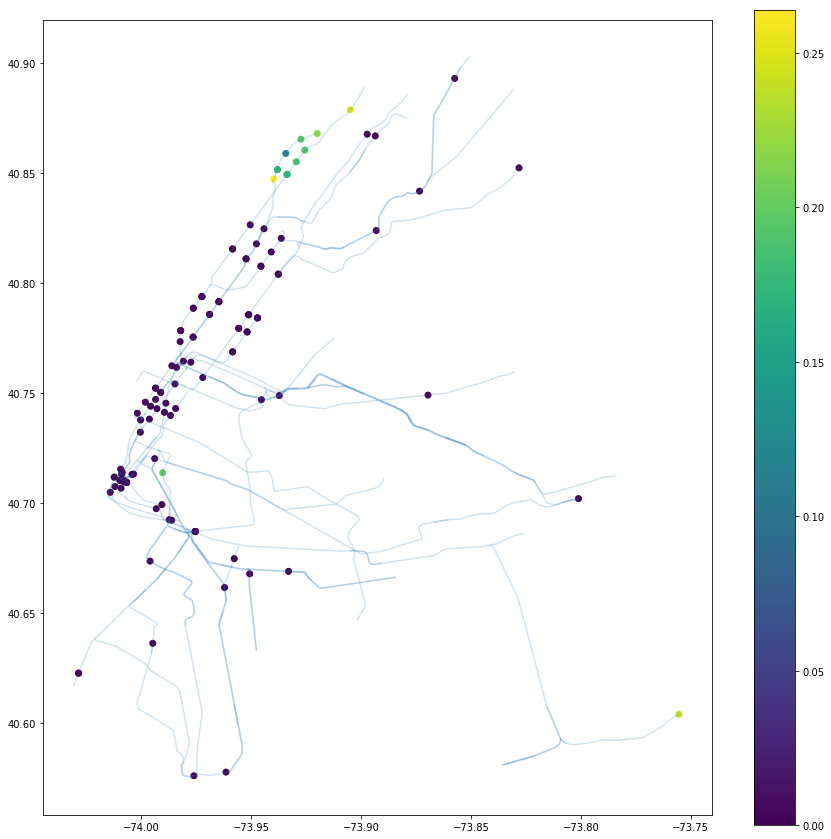

In [98]:
lines = gp.read_file(DATA_DIR+'Subway Lines.geojson')
fig,ax = plt.subplots(figsize=(15,15))
lines.plot(ax=ax, legend=True, alpha=0.2)
geo_plot_df.plot(column='day_score', ax=ax, legend=True)

In [47]:
geo_joined_daily_data.head()

In [49]:
geo_stations = geo_joined_daily_data[['name', 'line', 'geometry']].drop_duplicates()